In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import sklearn
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import LinearRegression  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import neighbors, metrics
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor

In [2]:
cons = pd.read_csv("df_vst_group8.csv",decimal='.')
cork = pd.read_csv("Corkstation_15072019_01022011.csv",nrows=12432,decimal='.')
donnees = pd.merge(cons,cork)

# Extraction de l'heure, des jours, jours de semaines, mois et années dans des colonnes séparées
donnees['date'] = pd.to_datetime(donnees['date'])
donnees['Heure'] = donnees['date'].dt.time.apply(lambda x: x.hour)
donnees['jour'] = donnees['date'].dt.date
donnees['weekday'] = donnees['date'].dt.weekday
donnees['month']= donnees['date'].dt.month
donnees['year'] = donnees['date'].dt.year


# Calcul de la température moyenne par jour et remplacement des valeurs de température par la température moyenne
temperature_moyenne = donnees.groupby('jour')['temp'].mean().reset_index()
temperature_moyenne = temperature_moyenne.rename(columns={'temp': 'temp_moyenne'})
donnees_merged = pd.merge(donnees, temperature_moyenne, on='jour')
donnees_merged['temp'] = donnees_merged['temp_moyenne']
donnees_merged = donnees_merged.drop([ 'temp_moyenne'], axis=1)

donnees = donnees_merged

#donnees contient les éléments de consommation et météo classés par date jusqu'au 14/12/2010
print(donnees)

                     date      mean       temp  ind  rain  ind.1  ind.2  wetb  \
0     2009-07-15 00:00:00  0.359623  14.954167    3   0.0      0      0  11.4   
1     2009-07-15 01:00:00  0.246548  14.954167    3   0.0      0      0  11.1   
2     2009-07-15 02:00:00  0.194699  14.954167    3   0.1      0      0  10.9   
3     2009-07-15 03:00:00  0.180482  14.954167    3   0.0      0      0  10.8   
4     2009-07-15 04:00:00  0.168851  14.954167    3   0.0      0      0  11.1   
...                   ...       ...        ...  ...   ...    ...    ...   ...   
12427 2010-12-14 19:00:00  1.047525   3.358333    3   0.0      0      0   1.1   
12428 2010-12-14 20:00:00  1.000873   3.358333    3   0.0      0      0   0.4   
12429 2010-12-14 21:00:00  0.948643   3.358333    3   0.0      0      1  -0.3   
12430 2010-12-14 22:00:00  0.837083   3.358333    3   0.0      1      1  -0.4   
12431 2010-12-14 23:00:00  0.699087   3.358333    3   0.0      0      1  -0.2   

       dewpt  vappr  ...   

In [3]:

# enlever les lignes sans consommation
donnees.dropna(inplace=True)


# Création de la matrice des paramètres de prédiction, et du vecteur de consommation 
X = donnees[['Heure','temp','weekday']]

y = donnees['mean']

# Sparation entre données d'entrainement et de test 

X_train = donnees.query('(month > 7 and year == 2009) or (month < 5) or (month > 7 and month < 11 and year == 2010) ')[['Heure','temp','weekday']]
X_test =  donnees.query('month > 10 and year == 2010')[['Heure','temp','weekday']]
Y_train = donnees.query('(month > 7 and year == 2009) or (month < 5) or (month > 7 and month < 11 and year == 2010) ')[['mean']]
Y_test =  donnees.query('month > 10 and year == 2010')[['mean']]

c:\Users\laure\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0, 0.5, 'consommation (kWh)')

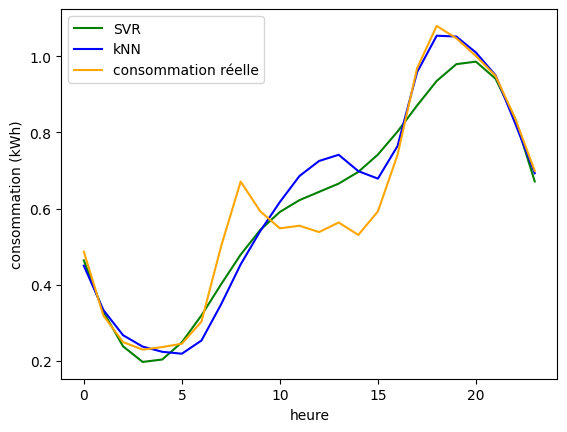

In [5]:
modelSVR = SVR(kernel = 'rbf')
modelSVR.fit(X_train, Y_train)

modelreg = linear_model.LinearRegression()
modelreg.fit(X_train, Y_train)

modelkNN = KNeighborsRegressor(20, weights='distance')
modelkNN.fit(X_train, Y_train)

x_pred = donnees.query('index > 12407')
y_predictedSVR = modelSVR.predict(x_pred[['Heure', 'temp','weekday']])
y_predictedkNN = modelkNN.predict(x_pred[['Heure', 'temp','weekday']])
plt.plot(x_pred['Heure'], y_predictedSVR, color = 'green' ,label='SVR')
plt.plot(x_pred['Heure'], y_predictedkNN, color = 'blue' ,label='kNN')
plt.plot(x_pred['Heure'], x_pred['mean'], color='orange', label='consommation réelle')
plt.legend()
plt.xlabel('heure')
plt.ylabel('consommation (kWh)')